In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams["figure.dpi"] = 200

# Problem 1

In [3]:
# I sure hope I'm allowed to do this using the convolution theorem
def convolve(arr1, arr2):
    """Convolve two arrays using the convolution theorem."""
    dtype = (arr1 + arr2).dtype
    return np.fft.ifft(np.fft.fft(arr1) * np.fft.fft(arr2)).astype(dtype)

In [4]:
def shift(arr, amount):
    """Shift an array by some number of indices using a convolution."""
    translator = np.zeros_like(arr)
    translator[amount] = 1
    return convolve(arr, translator)

In [5]:
xvals = np.linspace(-5, 5, 1000)
# Gaussian with unit variance
gaussian = np.exp(-0.5 * xvals ** 2) / np.sqrt(2 * np.pi)
shifted_gaussian = shift(gaussian, xvals.size // 5)

/home/bobby/anaconda3/envs/hera/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


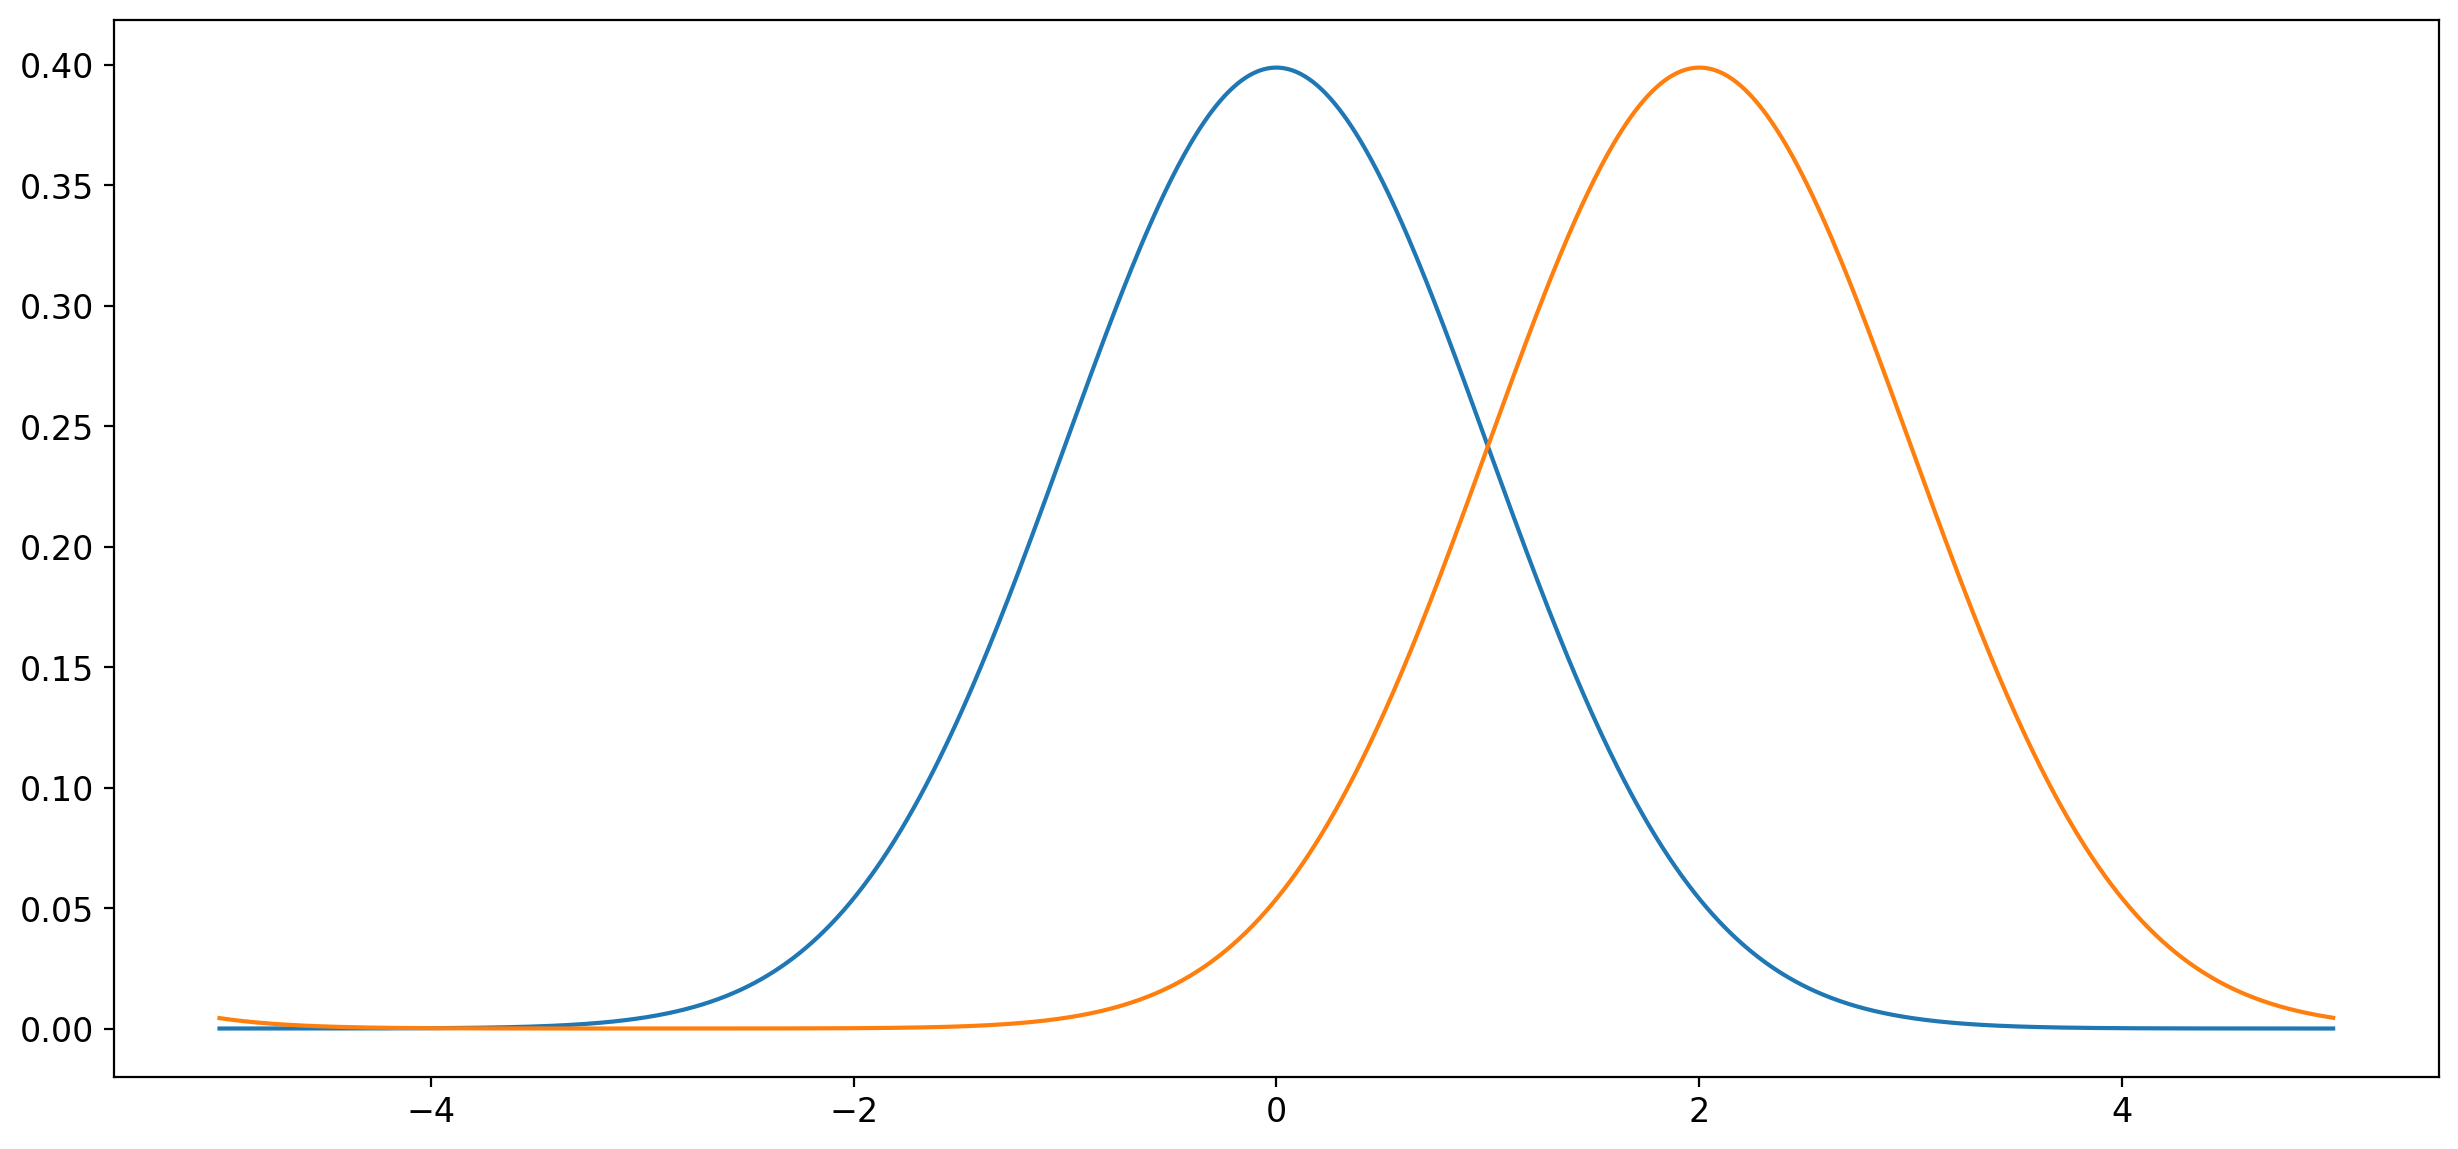

In [6]:
plt.plot(xvals, gaussian)
plt.plot(xvals, shifted_gaussian)

# Problem 2

In [7]:
def correlate(arr1, arr2):
    """Calculate the correlation function for two arrays."""
    dtype = (arr1 + arr2).dtype
    return np.fft.ifftshift(
        np.fft.ifft(np.fft.fft(arr1) * np.fft.fft(arr2).conj()).astype(dtype)
    )[::-1]

In [8]:
gaussian_autocorrelation = correlate(gaussian, gaussian)
correlation_xvals = np.linspace(-0.5, 0.5, xvals.size) * (xvals.max() - xvals.min())

/home/bobby/anaconda3/envs/hera/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


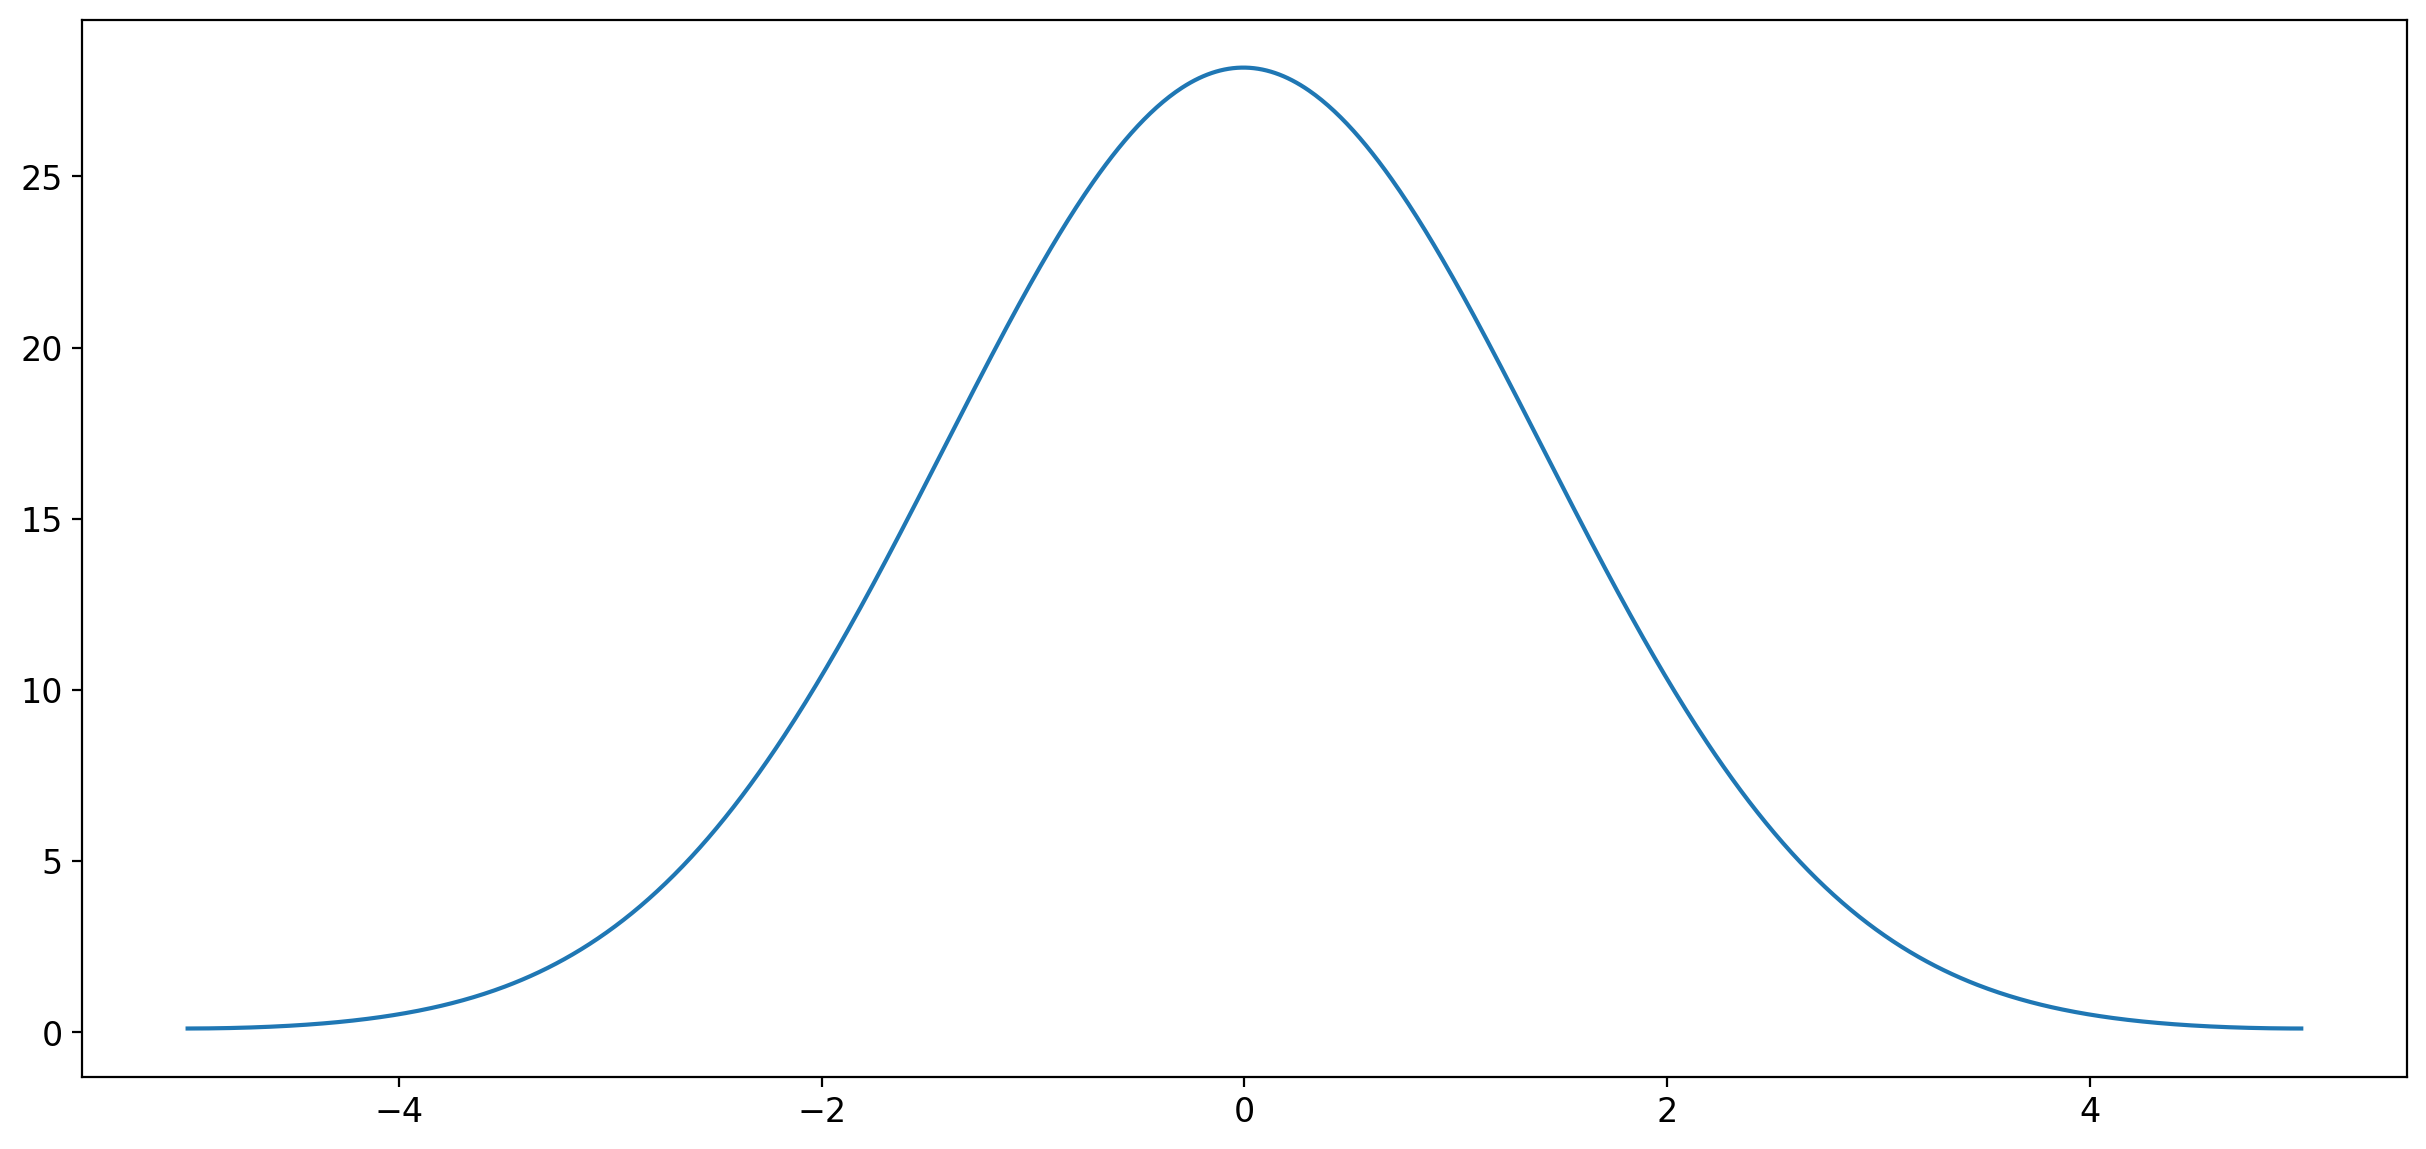

In [9]:
plt.plot(correlation_xvals, gaussian_autocorrelation)

# Problem 3

In [10]:
def shifted_correlation(arr1, arr2, amount):
    """Calculate the correlation of two arrays, with one shifted by some amount."""
    return correlate(arr1, shift(arr2, amount))

In [11]:
shift_lengths = (np.linspace(0, 1, 10, endpoint=False) * xvals.size).astype(int)
gaussian_autocorrs = np.array(
    [
        shifted_correlation(gaussian, gaussian, shift_length) 
        for shift_length in shift_lengths
    ]
)

/home/bobby/anaconda3/envs/hera/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


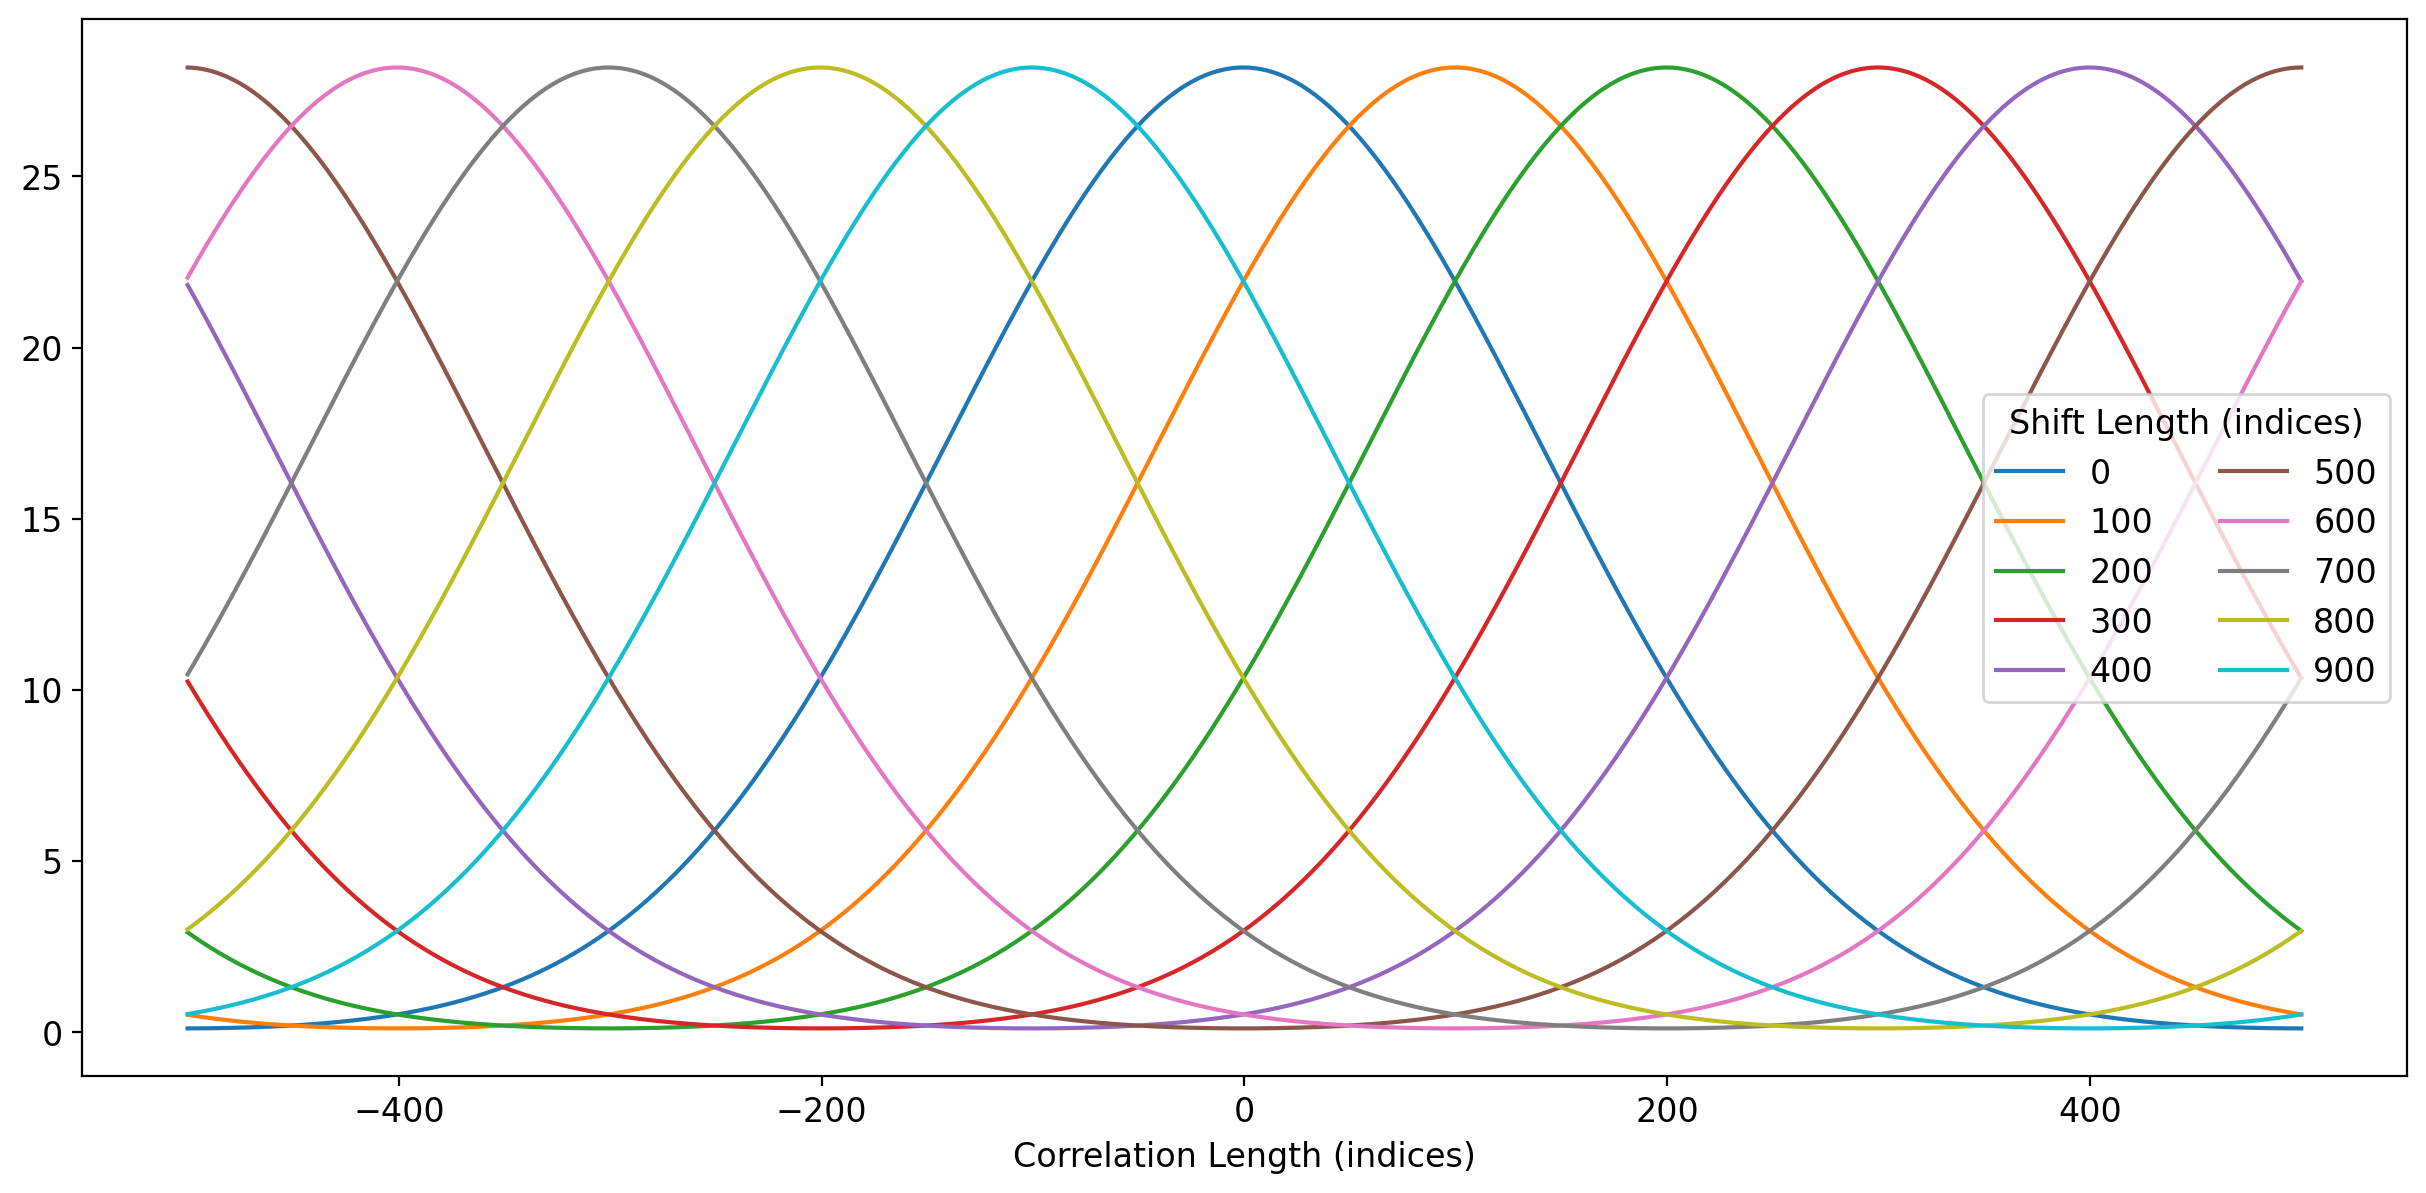

In [12]:
for autocorr, shift_length in zip(gaussian_autocorrs, shift_lengths):
    plt.plot(correlation_xvals * xvals.size / (xvals[-1] - xvals[0]), autocorr, label=shift_length)
plt.xlabel("Correlation Length (indices)")
plt.legend(title="Shift Length (indices)", ncol=2);

From the above plot, we can see that the correlation of a function with a shifted version of itself is peaked (unsurprisingly) at the correlation length corresponding to how much it was shifted. Let's give a quick proof of why this is unsurprising.

Recall the definition of the correlation of two functions $f$ and $g$:
  
$$
Corr(f,g)(y) = \int dx f(x)g(x+y).
$$
  
To see why the above result is unsurprising, let $g(x) = f(x-z)$ (this shifts $f$ horizontally by an amount $z$). Then
  
$$
Corr(f,g)(y) = \int dx f(x)f(x+y-z),
$$
  
which sure looks like it reaches its maximum value at $y=z$ (though a rigorous proof of *that* isn't immediately obvious to me, at least not without knowing more about $f$).

# Problem 4

In [13]:
def better_convolve(arr1, arr2, zeropad=5000):
    """Convolve two arrays while being careful about edge effects."""
    size = arr1.size
    arr1_zeropad = np.concatenate((arr1, np.zeros(zeropad, dtype=arr1.dtype)))
    arr2_zeropad = np.concatenate((arr2, np.zeros(zeropad, dtype=arr2.dtype)))
    return convolve(arr1_zeropad, arr2_zeropad)[:size]

In [14]:
# Test this using the detector example from class.
decay_rate = 50
hits = 50
times = np.linspace(0, 1000, 10000)
hit_indices = np.random.randint(0, times.size, hits)
hit_amplitudes = np.random.normal(loc=0, scale=3, size=hits) ** 2
measured_temps = np.zeros(times.size)
for index, amplitude in zip(hit_indices, hit_amplitudes):
    t0 = times[index]
    response = amplitude * np.exp(-(times - t0) / decay_rate)
    response = np.where(times < t0, 0, response)
    measured_temps += response
base_response = np.exp(-times / decay_rate)
impulses = np.zeros(times.size)
impulses[hit_indices] = hit_amplitudes
temps_from_conv = convolve(base_response, impulses)
temps_from_better_conv = better_convolve(base_response, impulses)

/home/bobby/anaconda3/envs/hera/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


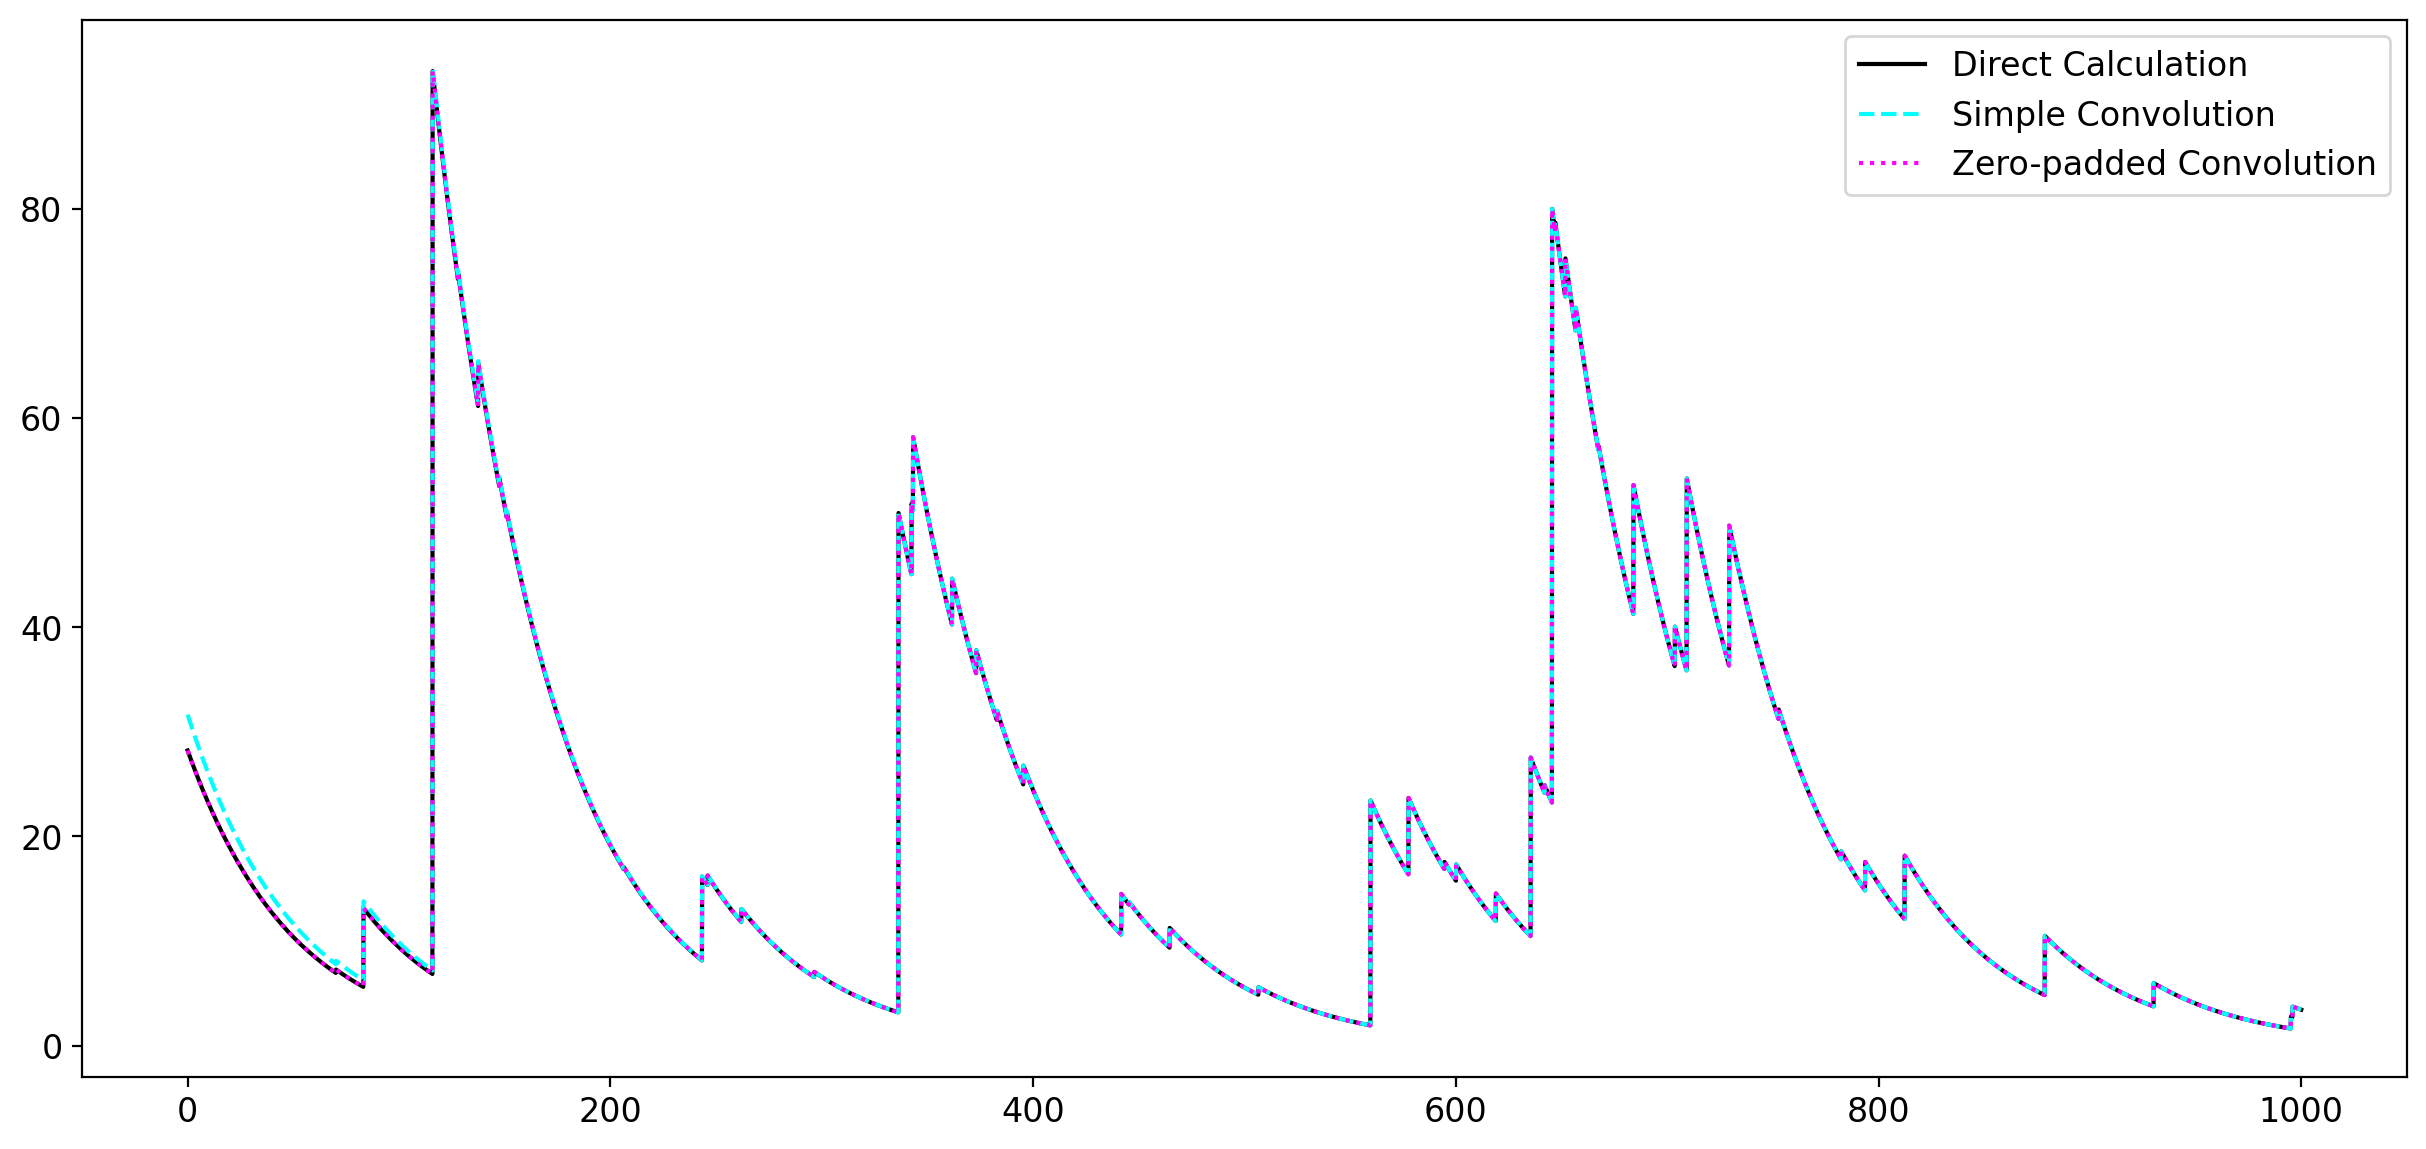

In [15]:
plt.plot(times, measured_temps, color='k', label="Direct Calculation")
plt.plot(times, temps_from_conv, ls='--', color='cyan', label="Simple Convolution")
plt.plot(times, temps_from_better_conv, ls=':', color='magenta', label="Zero-padded Convolution")
plt.legend();

# Problem 5

## Part a

We begin by showing that
  
$$
\sum_{n=0}^{N-1} \exp\bigl(-i2\pi kn/N\bigr) = \frac{1 - \exp\bigl(-i2\pi k\bigr)}{1 - \exp\bigl(-i2\pi k/N\bigr)}.
$$
  
Note that this looks like a finite geometric series $\sum \alpha^n$ with $\alpha = \exp\bigl(-i2\pi k/N\bigr)$. Now, the sum of a finite geometric series can be calculated as
  
$$
\begin{align}
\sum_{n=0}^{N-1}\alpha^n &= 1 + \alpha + \alpha^2 + \cdots + \alpha^{N-1} \\
&= \frac{(1-\alpha)(1 + \alpha + \cdots + \alpha^{N-1})}{1-\alpha} \\
&= \frac{1 - \alpha^N}{1 - \alpha}.
\end{align}
$$
  
So putting in $\alpha = \exp\bigl(-i2\pi k/N\bigr)$ gives us the desired result:
  
$$
\sum_{n=0}^{N-1} \exp\bigl(-i2\pi kn/N\bigr) = \frac{1 - \exp\bigl(-i2\pi k\bigr)}{1 - \exp\bigl(-i2\pi k/N\bigr)}.
$$

## Part b

We can determine how this behaves as $k \rightarrow 0$ analytically by using L'Hospital's Rule:
  
$$
\begin{align}
\lim_{k \rightarrow 0}\sum_{n=0}^{N-1}\exp\bigl(-i2\pi kn/N\bigr) &= \lim_{k \rightarrow 0}\frac{1 - \exp\bigl(-i2\pi k\bigr)}{1 - \exp\bigl(-i2\pi k/N\bigr)} \\
&= \lim_{k \rightarrow 0}\frac{i2\pi\exp\bigl(-i2\pi k\bigr)}{i2\pi/N\exp\bigl(-i2\pi k/N\bigr)} \\
&= N\lim_{k \rightarrow 0} \frac{\exp\bigl(-i2\pi k\bigr)}{\exp\bigl(-i2\pi k/N\bigr)} \\
&= N.
\end{align}
$$

For integer values of $k$ with $k \neq mN$ for some $m \in \mathbb{Z}$, the exponential in the numerator evaluates to 1, whereas the exponential in the denominator is some complex number that is not 1, so the sum is zero for $k \in \mathbb{Z}$ if $k \neq mN$ for some integer $m$. Now, if $k \in \mathbb{Z}$ **and** $k = mN$ for some $m \in \mathbb{Z}$, then the sum evaluates to $N$ by the same argument provided for $k \rightarrow 0$ (since the limit can just as well be evaluated via L'Hospital's Rule and its value is independent of the particular value of $k$ as long as the argument of both exponentials gives an integer multiple of $2\pi$).

## Part c

Let's begin by recalling definition of the DFT of a sequence:
  
$$
DFT[y_n] \equiv \sum_{n=0}^{N-1} y_n\exp\bigl(-i2\pi kn/N\bigr).
$$
  
Since we can write $\sin x$ as a linear combination of complex exponentials (and since the DFT operator is linear), I'll just consider the DFT of a complex exponential. For simplicity, I'll choose to write
  
$$
y_n = \exp\bigl(i2\pi k'n/N\bigr).
$$
  
By inspection, the DFT of this is the same as the sum from part (a), but with $k$ replaced by $k-k'$, so we have
  
$$
DFT\Bigl[\exp\bigl(i2\pi k'n/N\bigr)\Bigr] = \frac{1 - \exp\bigl(-i2\pi(k-k')\bigr)}{1 - \exp\bigl(-i2\pi(k-k')/N\bigr)}.
$$

In [16]:
# Let's check how close we are...
N = 501
k = 10.3
y_n = np.exp(2j * np.pi * k * np.arange(N) / N)
ks = np.fft.fftshift(np.fft.fftfreq(N, 1/N))
analytic_dft = (1 - np.exp(-2j * np.pi * (ks-k))) / (1 - np.exp(-2j * np.pi * (ks-k) / N))
analytic_dft[np.isnan(analytic_dft)] = N
numerical_dft = np.fft.fftshift(np.fft.fft(y_n))

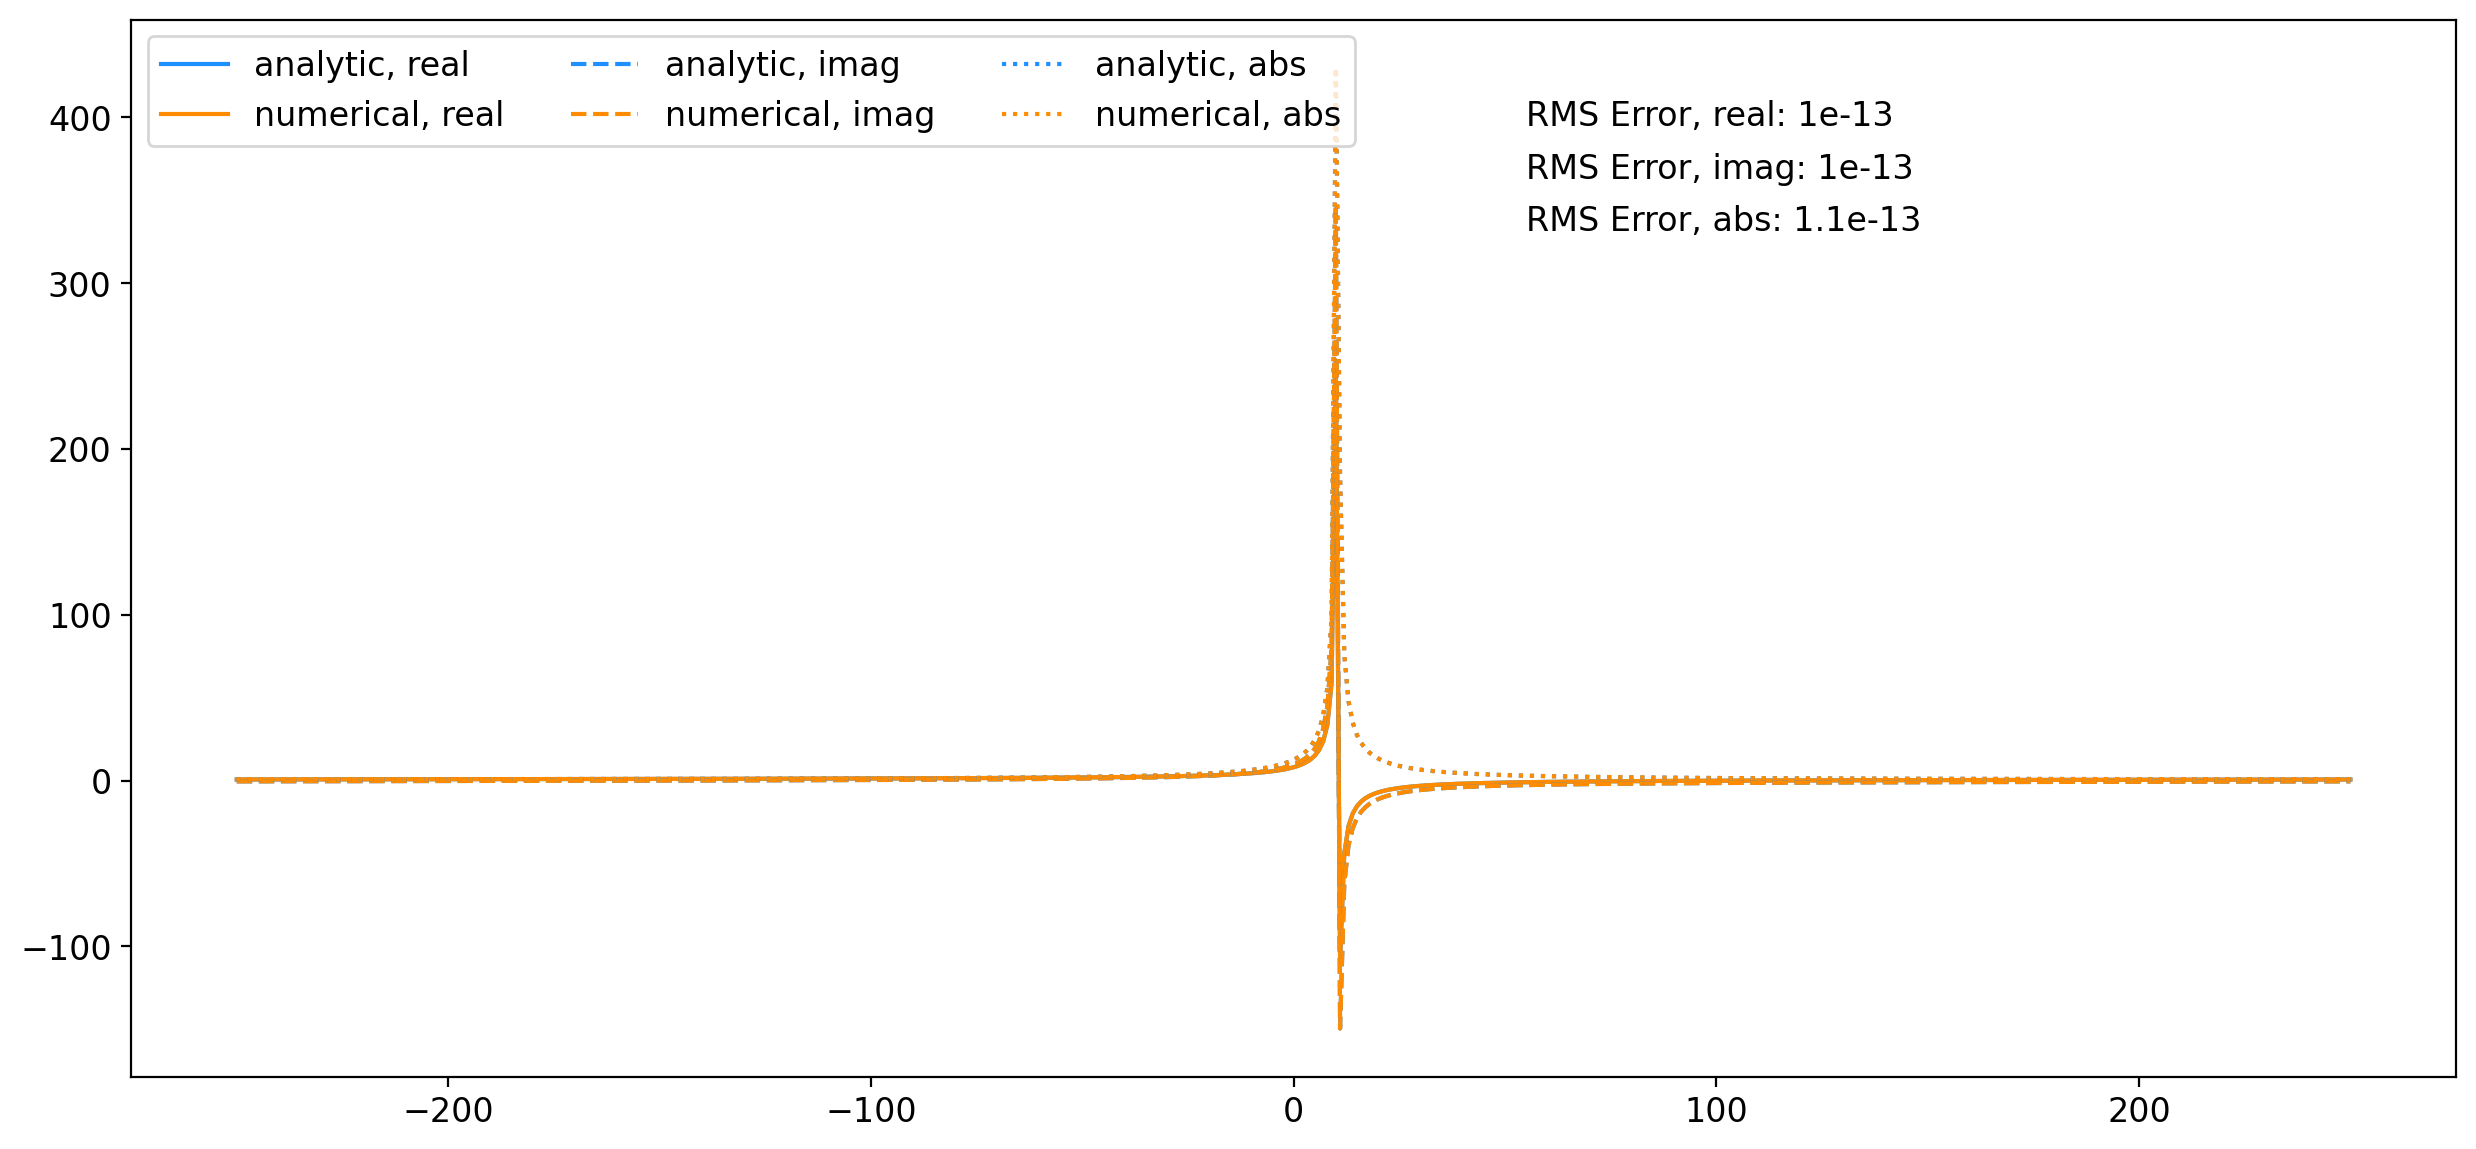

In [17]:
fig, ax = plt.subplots(1)
for i, (cmp, ls) in enumerate(zip(("real", "imag", "abs"), ("-", "--", ":"))):
    analytic_result = getattr(np, cmp)(analytic_dft)
    numerical_result = getattr(np, cmp)(numerical_dft)
    rms_error = np.std(analytic_result - numerical_result)
    ax.plot(ks, analytic_result, color="dodgerblue", ls=ls, label=f"analytic, {cmp}")
    ax.plot(ks, numerical_result, color="darkorange", ls=ls, label=f"numerical, {cmp}")
    ax.text(0.6, 0.9 - 0.05 * i, f"RMS Error, {cmp}: {rms_error:.2}", transform=ax.transAxes)
plt.legend(ncol=3, loc="upper left");

Looks like each DFT agrees with the analytic result to machine precision&mdash;nice!
  
It looks like the amplitude of the DFT is spiked at the frequency of the input sine wave, but it's clearly not a delta function&mdash;there's significant leakage to nearby frequencies! Here's a closer look...

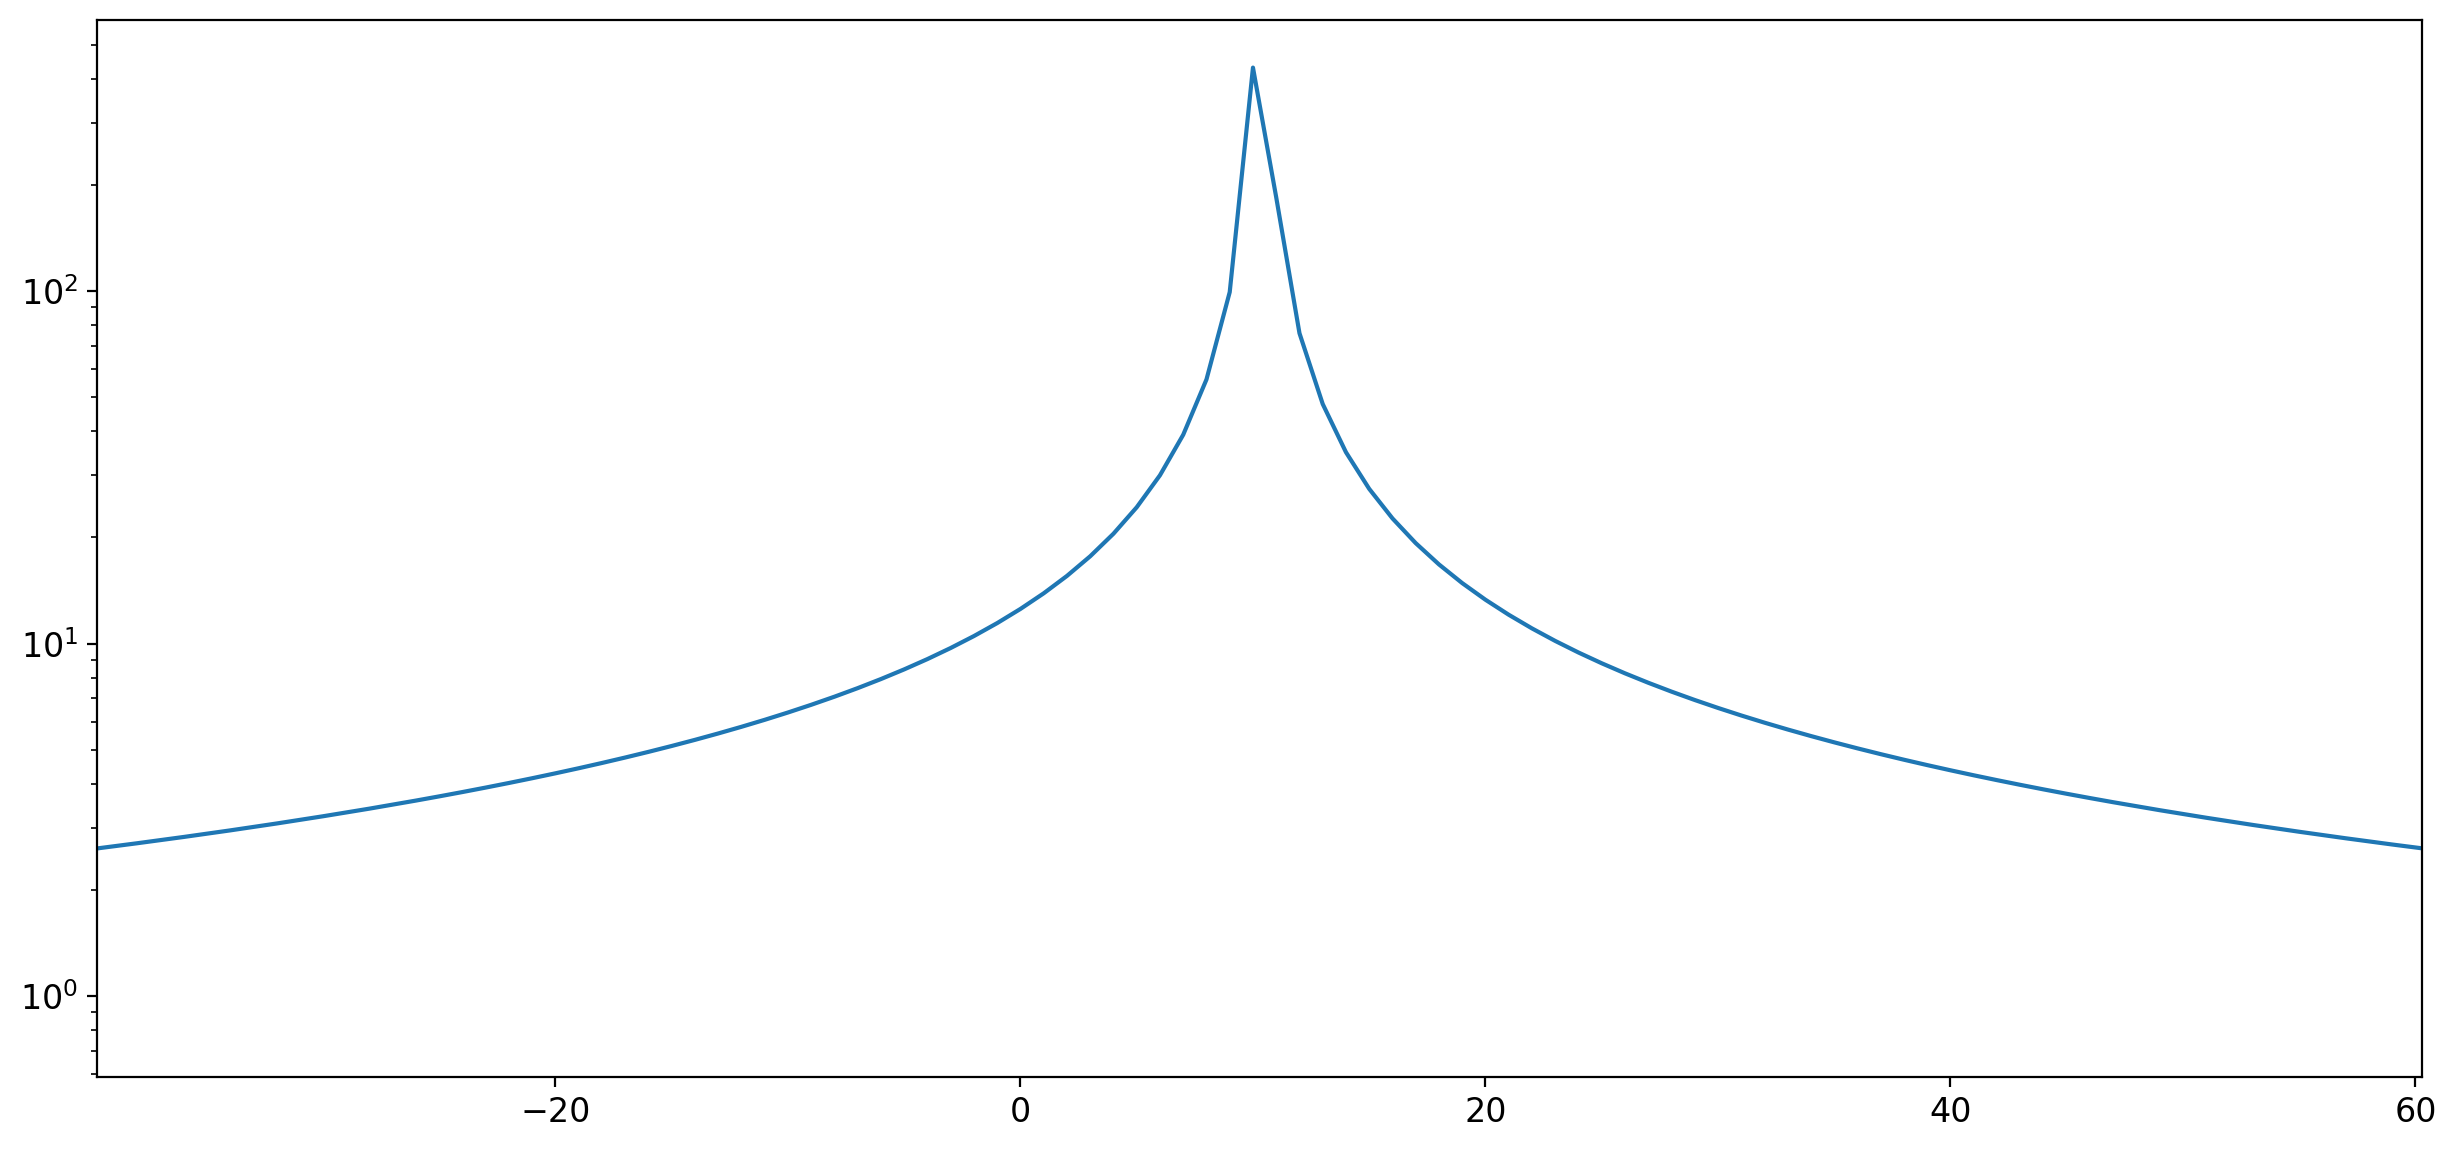

In [18]:
plt.semilogy(ks, np.abs(analytic_dft))
plt.xlim(k - 50, k + 50);

## Part d

In [19]:
k = 3.772
y_n = np.exp(2j * np.pi * k * np.arange(N) / N)
window = 0.5 * (1 - np.cos(2 * np.pi * np.arange(N) / N))
non_windowed_fft = np.fft.fftshift(np.fft.fft(y_n))
windowed_fft = np.fft.fftshift(np.fft.fft(window * y_n))

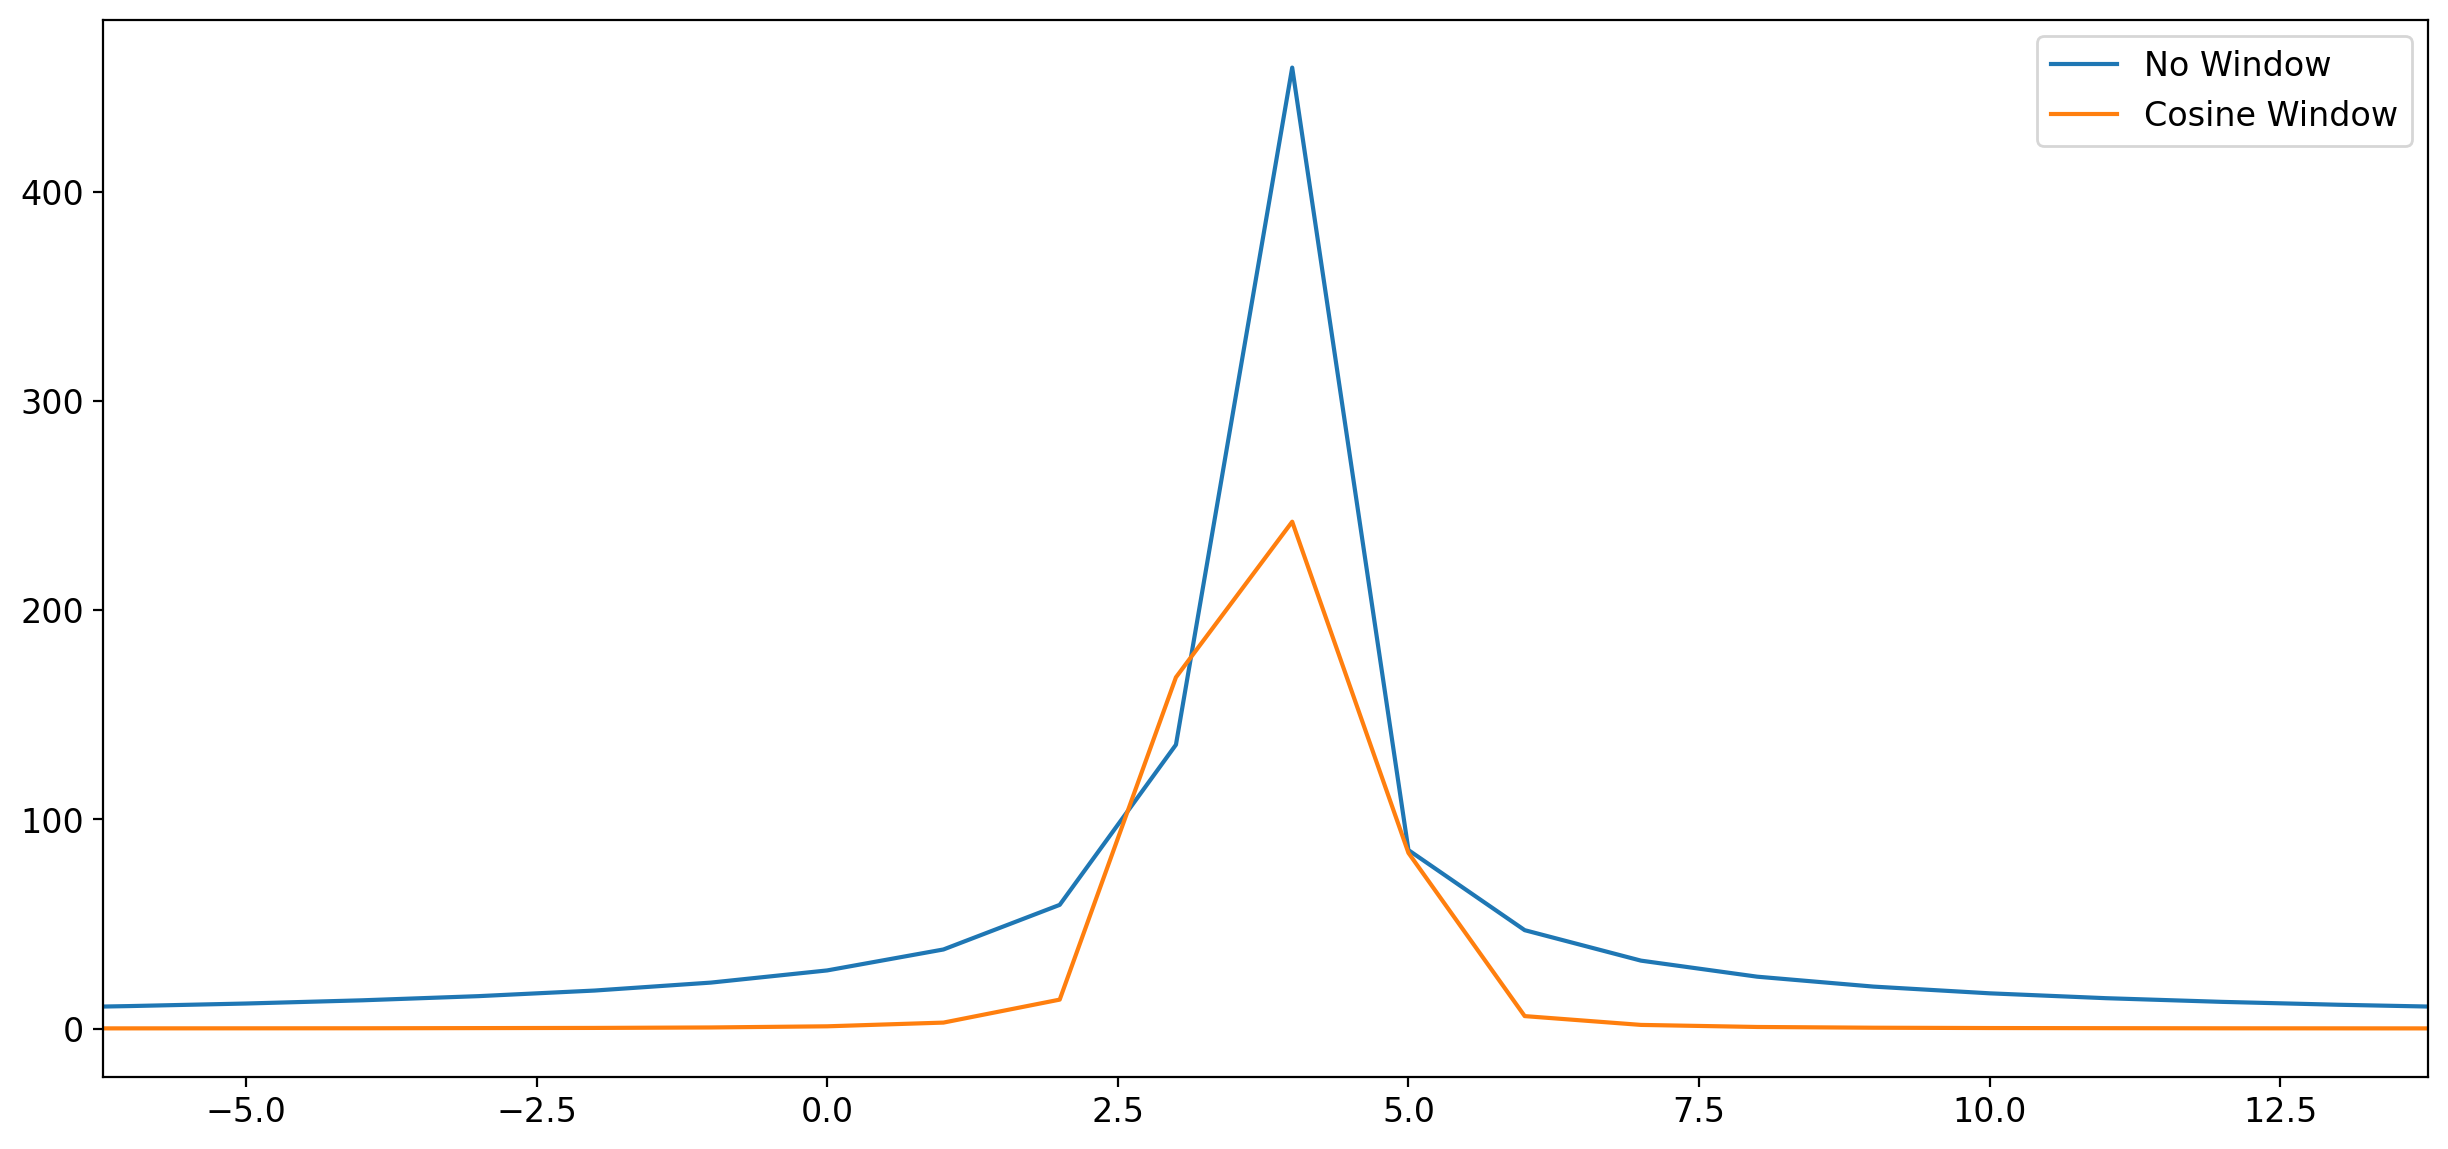

In [20]:
plt.plot(ks, np.abs(non_windowed_fft), label="No Window")
plt.plot(ks, np.abs(windowed_fft), label="Cosine Window")
plt.xlim(k - 10, k + 10)
plt.legend();

Note that the windowed DFT has significant sidelobe suppression, though the shape is a little wonky near the frequency of the input sine wave. (I suspect this is likely just an issue related to low resolution in Fourier space near the peak.)

## Part e

I'm feeling a little lazy, so I'm just going to do this part numerically.

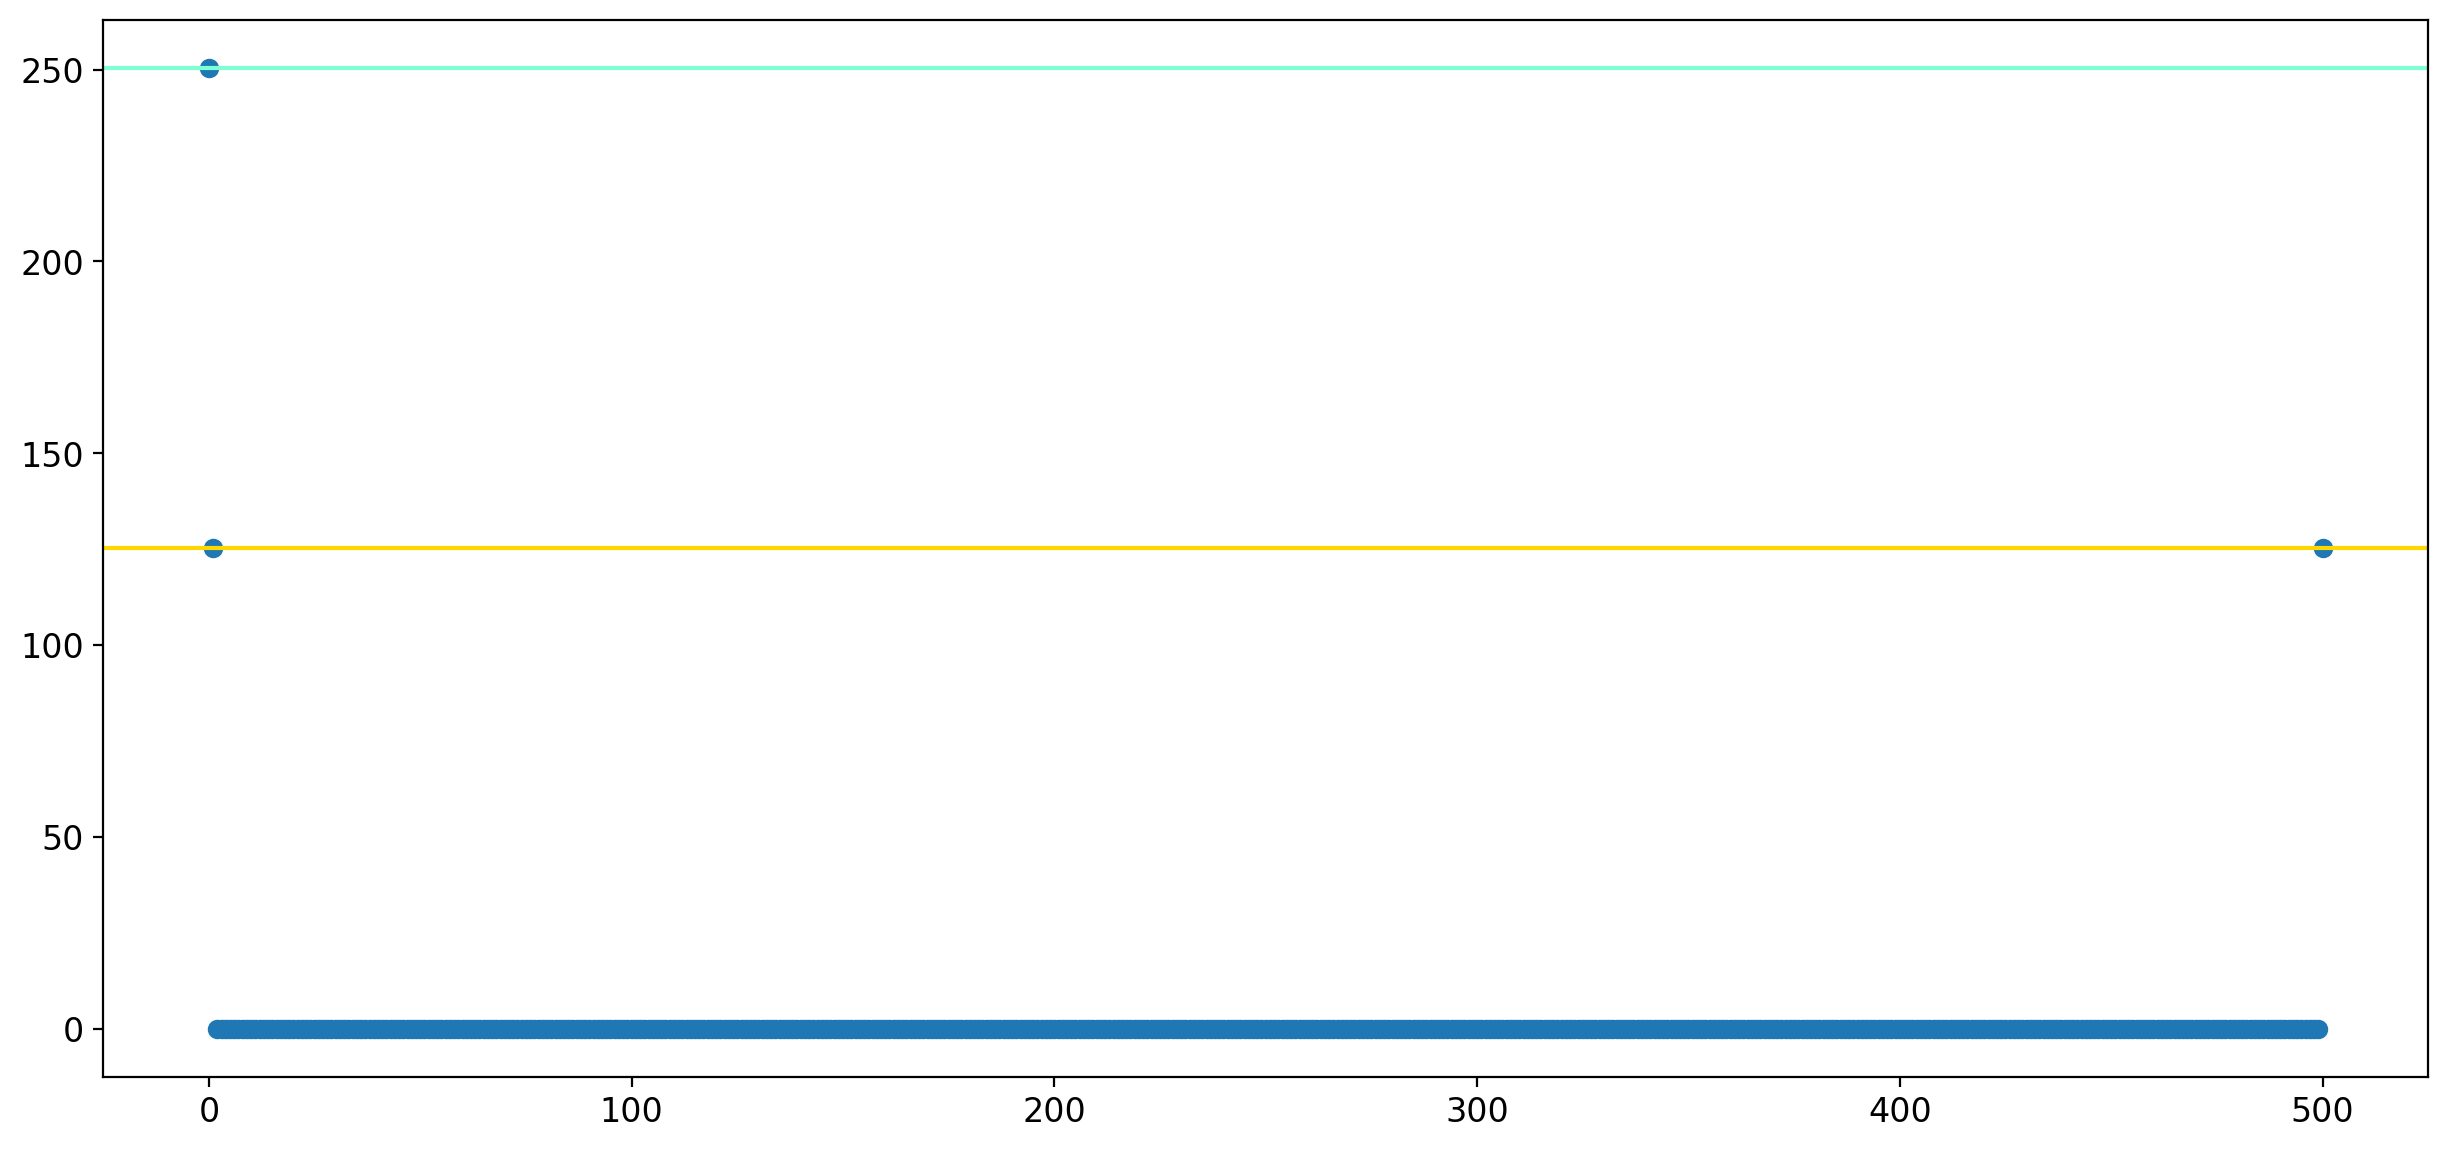

In [21]:
numerical_window_dft = np.fft.fft(window)
plt.plot(np.abs(numerical_window_dft), lw=0, marker='o')
plt.axhline(N / 2, color="aquamarine")
plt.axhline(N / 4, color="gold");

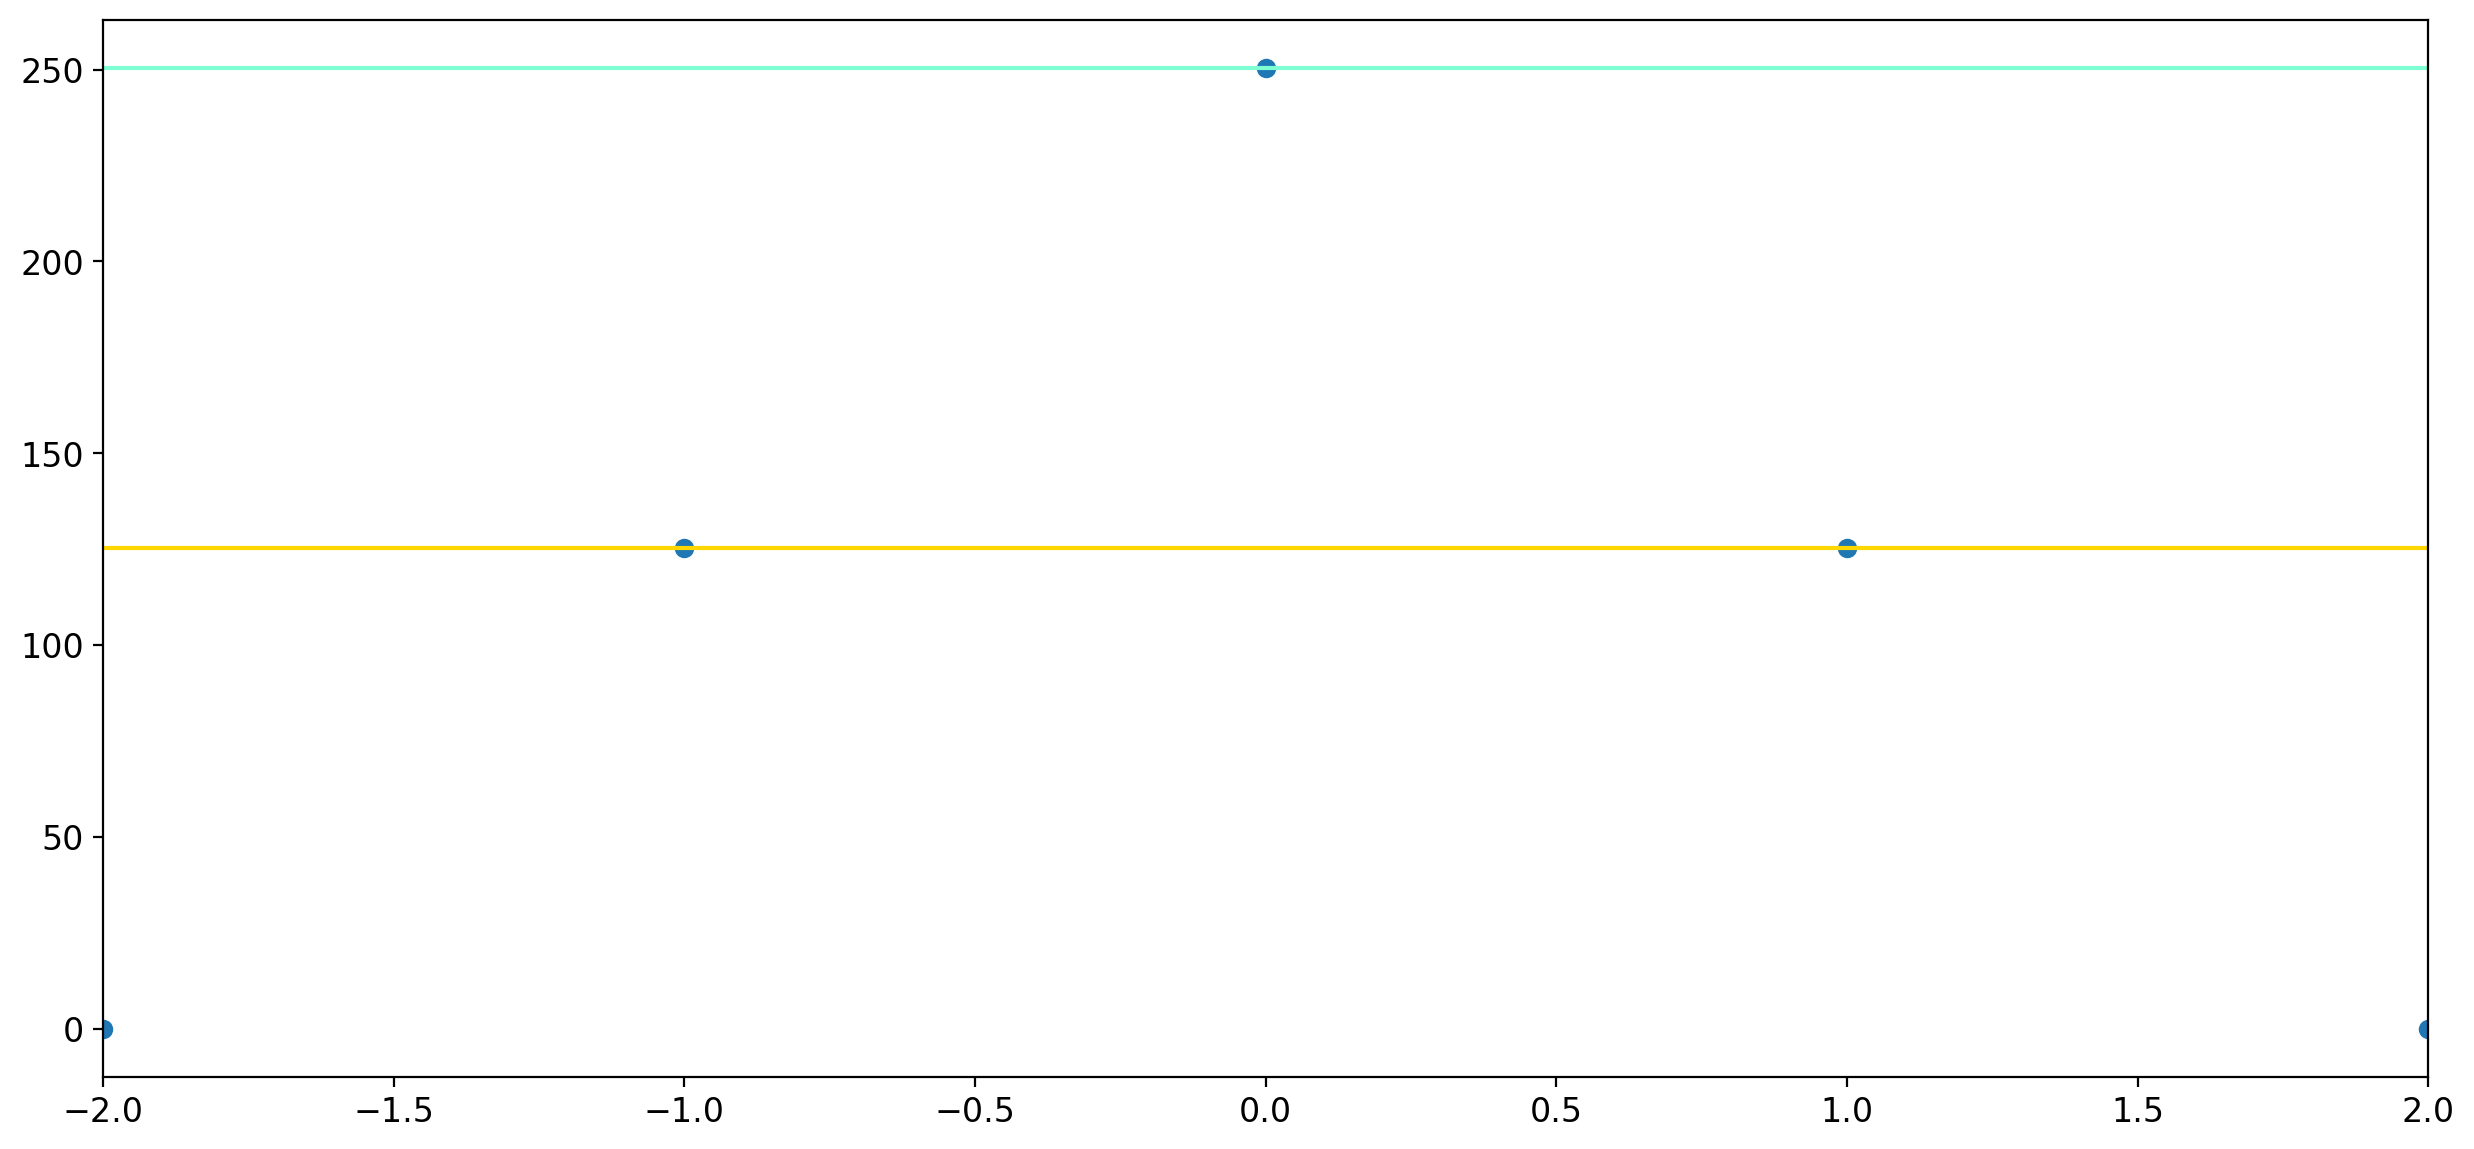

In [22]:
# Once more, but this time actually show frequencies...
plt.plot(ks, np.abs(np.fft.fftshift(numerical_window_dft)), lw=0, marker='o')
plt.axhline(N/4, color="gold")
plt.axhline(N/2, color="aquamarine")
plt.xlim(-2, 2);

So we've shown that the DFT of this transform gives a convolving kernel that takes a weighted sum of a point and its two neighboring points. Remembering that the Fourier Transform of a product of functions in one space is the convolution of each function's Fourier Transform in the dual space, and keeping the above plot in mind, it follows that applying a window function to data before taking the DFT effectively modifies the resulting DFT by replacing each point with the weighted sum of that point and its neighboring points, with the weights and kernel width determined entirely by the window.

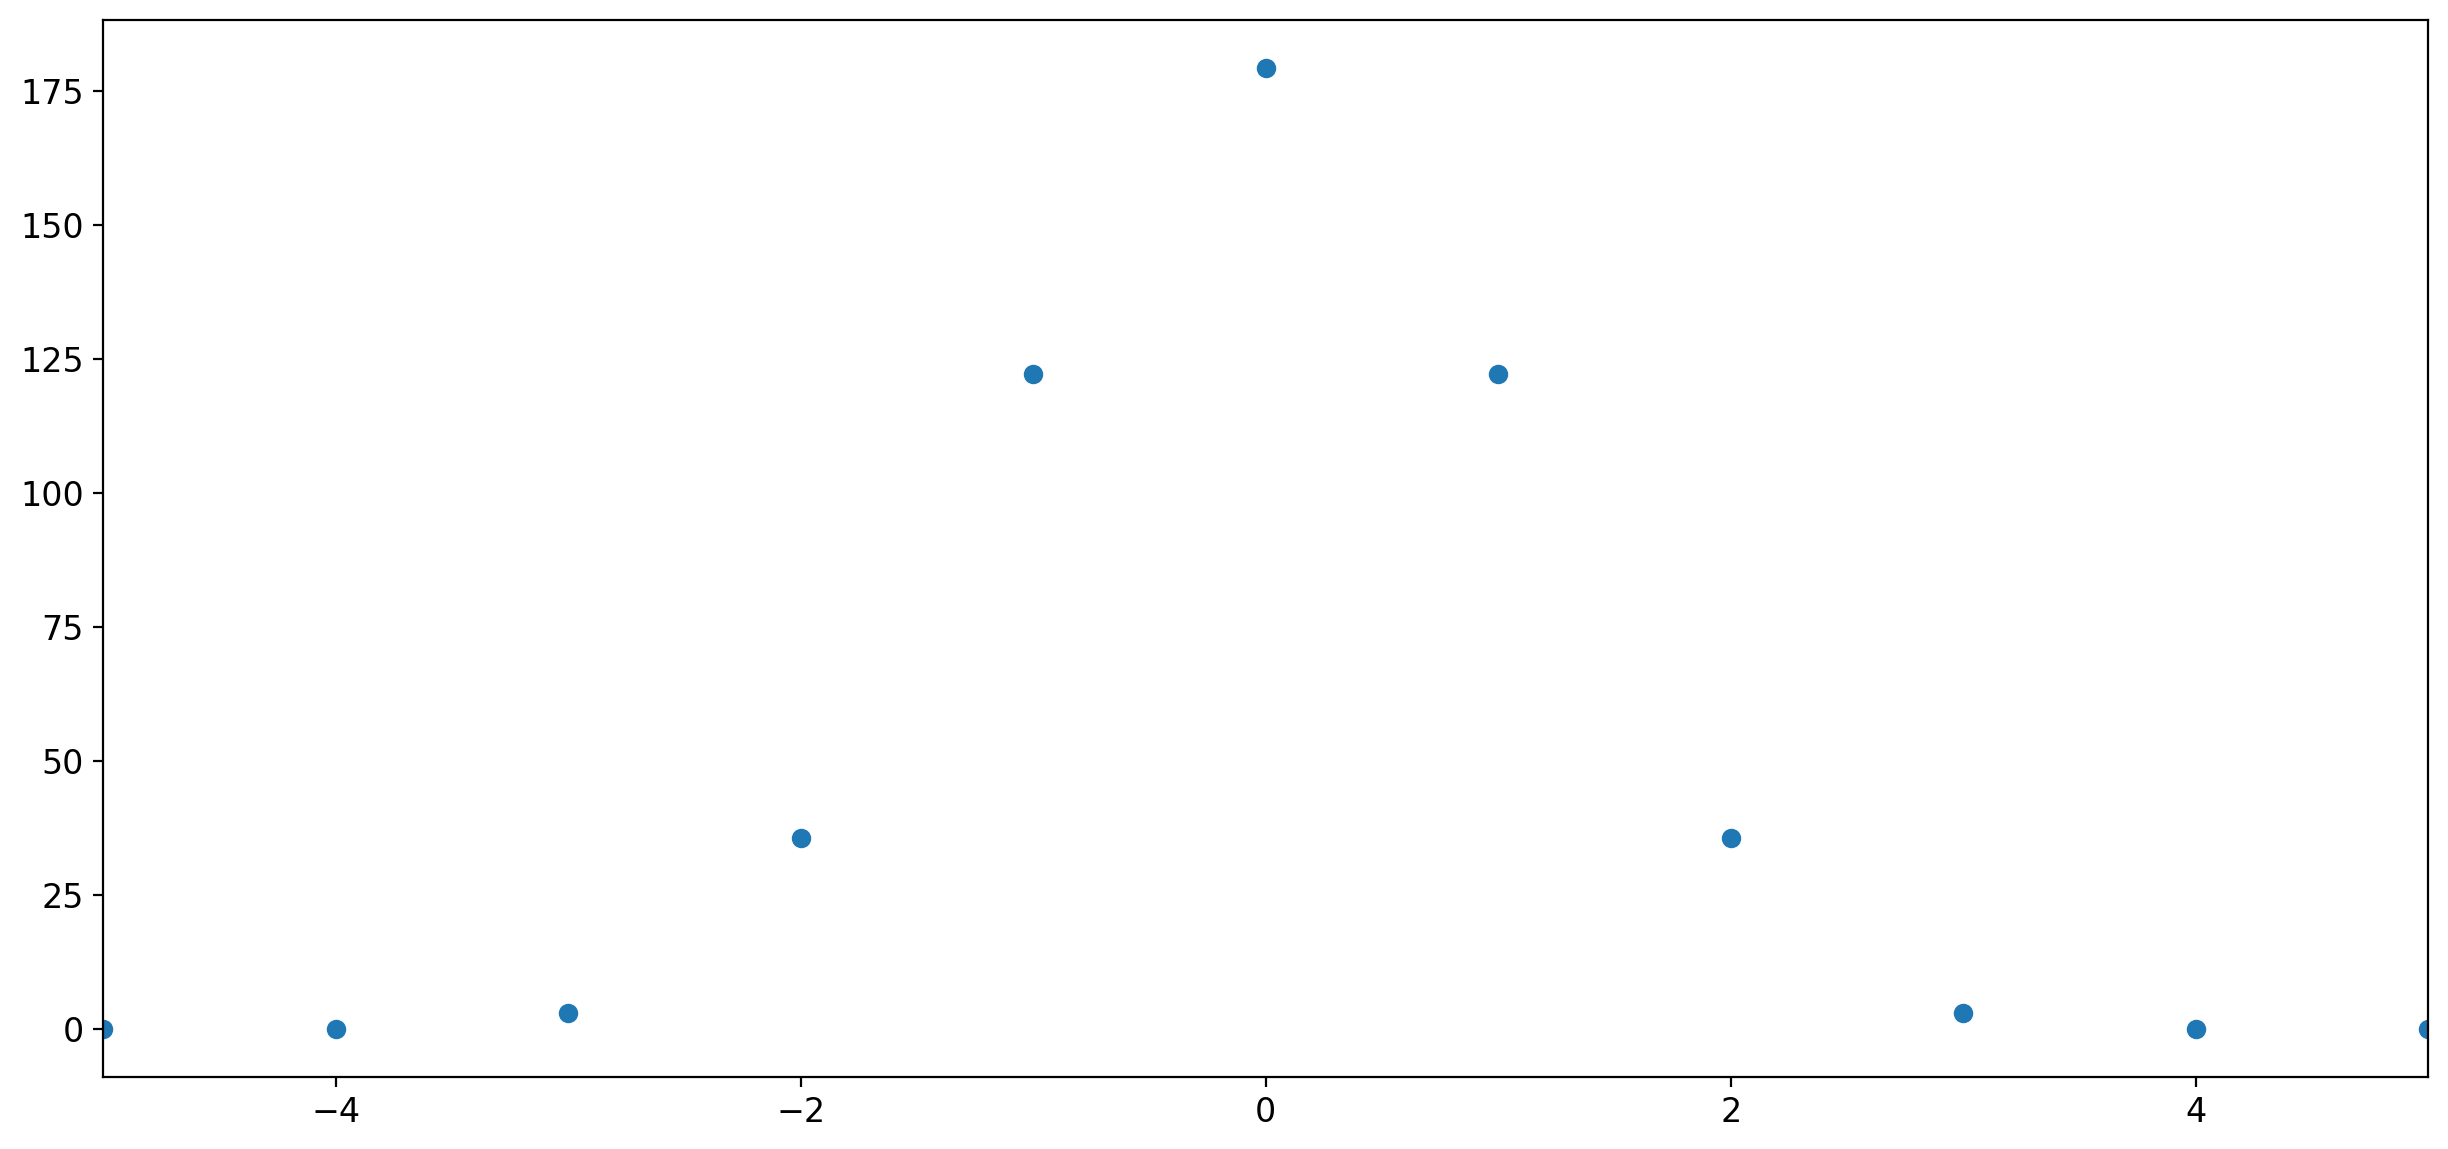

In [23]:
# Here's another example
from scipy.signal import windows
bh = windows.blackmanharris(N)
bh_dft = np.fft.fftshift(np.fft.fft(bh))
plt.plot(ks, np.abs(bh_dft), marker='o', lw=0)
plt.xlim(-5, 5);

So it looks like the Blackman-Harris window makes a convolving kernel that takes a weighted sum of a point with the neighboring 2~3 points on either side of it. (This is my go-to window for EoR stuff&mdash;I've been taught that it's very good for killing sidelobes when you need a very high dynamic range, and using it in my work suggests that the folks who taught me this weren't telling me lies.)